In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as ro
import gffutils 
import textwrap
from gprofiler import GProfiler
from rpy2.robjects import default_converter, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

In [ ]:
# Import DESeq2
utils = importr('utils')
try:
    deseq2 = importr('DESeq2')
except:
    utils.install_packages("BiocManager")
    biocmanager = importr("BiocManager")
    biocmanager.install("DESeq2")
    deseq2 = importr('DESeq2')

In [55]:
cd transcriptome_workflow_analysis/

/Users/mj/Desktop/Projects/transcriptome_workflow_analysis


In [ ]:

gene_counts = pd.read_csv("results/gene_count_matrix.csv")
metadata = pd.read_csv("notebooks/metadata.csv")

metadata["condition"] = metadata["condition"].astype("category")
metadata = metadata.set_index("sample")

gene_counts.iloc[:, 1:] = gene_counts.iloc[:, 1:].apply(pd.to_numeric, errors="coerce").fillna(0)

In [ ]:
with localconverter(default_converter + pandas2ri.converter):
    r_counts = ro.conversion.py2rpy(gene_counts.set_index("gene_id"))
    r_coldata = ro.conversion.py2rpy(metadata)

dds = deseq2.DESeqDataSetFromMatrix(
    countData=r_counts,
    colData=r_coldata,
    design=ro.Formula("~ condition")
)
dds = deseq2.DESeq(dds)
res = deseq2.results(dds)

with localconverter(default_converter + pandas2ri.converter):
    res_df = ro.conversion.rpy2py(ro.r("as.data.frame")(res))

res_df["gene_id"] = res_df.index
res_df = res_df.reset_index(drop=True)

R callback write-console: estimating size factors
  
R callback write-console: estimating dispersions
  
R callback write-console: gene-wise dispersion estimates
  
R callback write-console: mean-dispersion relationship
  
R callback write-console: final dispersion estimates
  
R callback write-console: fitting model and testing
  


In [ ]:
# baseMean > 10 filter
res_filt = res_df[res_df["baseMean"] > 10].copy()

# log2FoldChange > 0 → gene is upregulated in "cold" condition
# log2FoldChange <= 0 → gene is downregulated in "cold" condition
res_filt["direction"] = np.where(res_filt["log2FoldChange"] > 0, "up_in_cold", "down_in_cold")


In [87]:
# Significant DEGs: |log2FC| > 1 and padj < 0.05
de_genes_sig = res_filt[(res_filt["log2FoldChange"].abs() > 1) & (res_filt["padj"] < 0.05)]
de_genes_sig = de_genes_sig.sort_values("log2FoldChange", ascending=False)

print("Genes after baseMean > 10 filter:", res_filt.shape[0])
print("Significant genes |log2FC| > 1 and padj < 0.05:", de_genes_sig.shape[0])


Genes after baseMean > 10 filter: 29862
Significant genes |log2FC| > 1 and padj < 0.05: 2017


<Figure size 1200x1000 with 0 Axes>

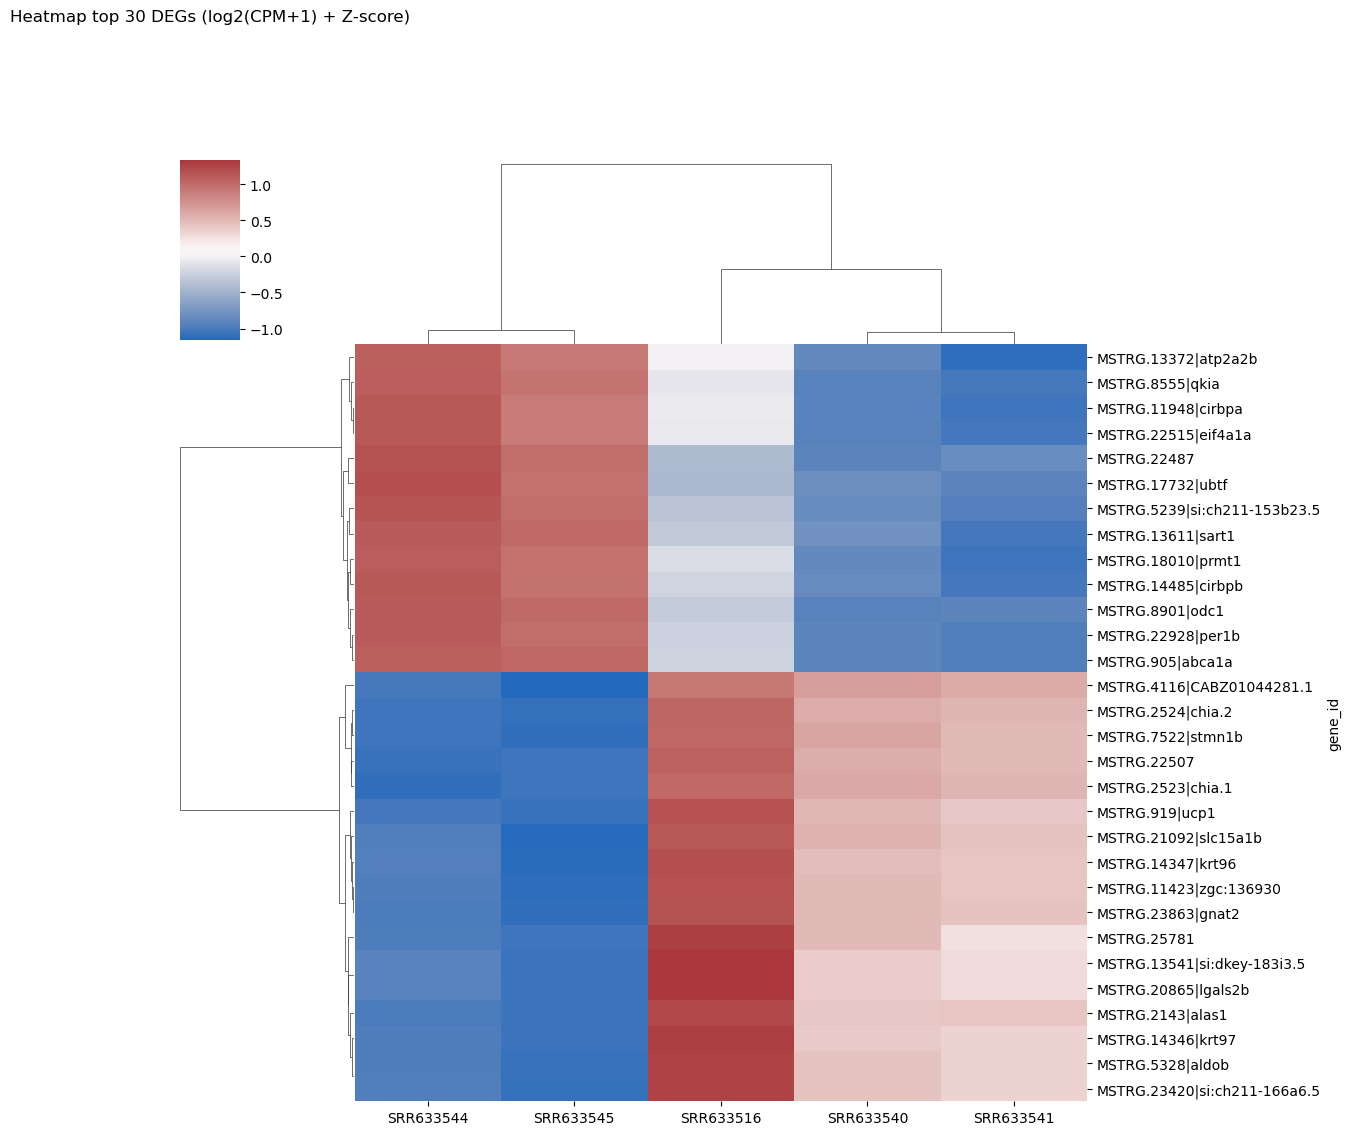

In [ ]:
# Select the top 30 DEGs by p-value
top_genes = de_genes_sig.sort_values("pvalue").head(30)["gene_id"].tolist()
heatmap_data = gene_counts.set_index("gene_id").loc[top_genes]
heatmap_data = np.log2(heatmap_data + 1)

# Z-score normalization per gene
heatmap_data_z = (heatmap_data - heatmap_data.mean(axis=1).values[:, None]) / heatmap_data.std(axis=1).values[:, None]

# Heatmap with clustering
plt.figure(figsize=(12,10))
g = sns.clustermap(
    heatmap_data_z,
    cmap="vlag",
    row_cluster=True,
    col_cluster=True,
    figsize=(12,10)
)

plt.title("Heatmap top 30 DEGs (log2(CPM+1) + Z-score)", pad=100)
plt.show()


In [ ]:
gene_counts = pd.read_csv("results/gene_count_matrix.csv")
gtf_file = "data/genome/Danio_rerio.GRCz11.109.gtf"

In [ ]:
gene_counts = pd.read_csv("results/gene_count_matrix.csv")

gene_counts["gene_symbol"] = gene_counts["gene_id"].str.split("|").str[1]

gene_counts.head()


,gene_id,SRR633516,SRR633540,SRR633541,SRR633544,SRR633545,gene_symbol
0,MSTRG.1|rpl24,1926,1684,509,6319,1149,rpl24
1,MSTRG.2|cep97,131,75,72,89,96,cep97
2,MSTRG.1,8344,5017,5923,0,4851,NaN
3,MSTRG.3|nfkbiz,109,81,64,88,87,nfkbiz
4,MSTRG.4|eed,219,129,136,101,119,eed


In [67]:
gene_counts_clean = gene_counts.dropna(subset=["gene_symbol"])
print("Geni con simbolo:", gene_counts_clean.shape[0])

Geni con simbolo: 32467


In [ ]:
gp = GProfiler(return_dataframe=True)

# Map the gene symbols to Ensembl gene IDs (ENSG)
mapping = gp.convert(
    organism="drerio",
    query=gene_counts_clean["gene_symbol"].unique().tolist(),
    target_namespace="ENSG"
)



,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,rpl24,ENSDARG00000099104,1,1,rpl24,ribosomal protein L24 [Source:ZFIN;Acc:ZDB-GEN...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
1,cep97,ENSDARG00000102407,2,1,cep97,centrosomal protein 97 [Source:ZFIN;Acc:ZDB-GE...,"ENTREZGENE,WIKIGENE,ZFIN_ID",query_1
2,nfkbiz,ENSDARG00000102097,3,1,NFKBIZ,NFKB inhibitor zeta [Source:HGNC Symbol;Acc:HG...,"ENTREZGENE,HGNC,WIKIGENE",query_1
3,eed,ENSDARG00000099640,4,1,eed,embryonic ectoderm development [Source:ZFIN;Ac...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
4,hikeshi,ENSDARG00000104071,5,1,hikeshi,heat shock protein nuclear import factor hikes...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
...,...,...,...,...,...,...,...,...
295,CR847936.6,ENSDARG00000110922,265,1,ENSDARG00000110922,None,CLONE_BASED_ENSEMBL_GENE,query_1
296,CR847936.10,ENSDARG00000117482,266,1,ENSDARG00000117482,None,CLONE_BASED_ENSEMBL_GENE,query_1
297,CR847936.2,ENSDARG00000103921,267,1,ENSDARG00000103921,None,CLONE_BASED_ENSEMBL_GENE,query_1
298,CR847936.8,ENSDARG00000114198,268,1,ENSDARG00000114198,None,CLONE_BASED_ENSEMBL_GENE,query_1


In [70]:
mapping.head()

,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,rpl24,ENSDARG00000099104,1,1,rpl24,ribosomal protein L24 [Source:ZFIN;Acc:ZDB-GEN...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
1,cep97,ENSDARG00000102407,2,1,cep97,centrosomal protein 97 [Source:ZFIN;Acc:ZDB-GE...,"ENTREZGENE,WIKIGENE,ZFIN_ID",query_1
2,nfkbiz,ENSDARG00000102097,3,1,NFKBIZ,NFKB inhibitor zeta [Source:HGNC Symbol;Acc:HG...,"ENTREZGENE,HGNC,WIKIGENE",query_1
3,eed,ENSDARG00000099640,4,1,eed,embryonic ectoderm development [Source:ZFIN;Ac...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
4,hikeshi,ENSDARG00000104071,5,1,hikeshi,heat shock protein nuclear import factor hikes...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1


In [ ]:
# Merge the original gene counts with the mapping
# Only keeps genes that were successfully mapped
gene_counts_mapped = gene_counts_clean.merge(
    mapping,
    left_on="gene_symbol",
    right_on="incoming",
    how="inner"
)

gene_counts_mapped.head()


,gene_id,SRR633516,SRR633540,SRR633541,SRR633544,SRR633545,gene_symbol,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,MSTRG.1|rpl24,1926,1684,509,6319,1149,rpl24,rpl24,ENSDARG00000099104,1,1,rpl24,ribosomal protein L24 [Source:ZFIN;Acc:ZDB-GEN...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
1,MSTRG.2|cep97,131,75,72,89,96,cep97,cep97,ENSDARG00000102407,2,1,cep97,centrosomal protein 97 [Source:ZFIN;Acc:ZDB-GE...,"ENTREZGENE,WIKIGENE,ZFIN_ID",query_1
2,MSTRG.3|nfkbiz,109,81,64,88,87,nfkbiz,nfkbiz,ENSDARG00000102097,3,1,NFKBIZ,NFKB inhibitor zeta [Source:HGNC Symbol;Acc:HG...,"ENTREZGENE,HGNC,WIKIGENE",query_1
3,MSTRG.4|eed,219,129,136,101,119,eed,eed,ENSDARG00000099640,4,1,eed,embryonic ectoderm development [Source:ZFIN;Ac...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1
4,MSTRG.5|hikeshi,161,117,91,57,51,hikeshi,hikeshi,ENSDARG00000104071,5,1,hikeshi,heat shock protein nuclear import factor hikes...,"ENTREZGENE,UNIPROT_GN,WIKIGENE,ZFIN_ID",query_1


In [ ]:
gene_counts_mapped.to_csv(
    "results/gene_counts_with_ensembl.csv",
    index=False
)


In [ ]:

df = pd.read_csv("results/gene_counts_with_ensembl.csv")
de = de_genes_sig.copy()

# Keep only the DEGs that have an Ensembl ID 
deg_ensembl = (
    de.merge(df[["gene_id", "converted"]], on="gene_id", how="left")
      .dropna(subset=["converted"])
)

gene_list = deg_ensembl["converted"].unique().tolist()

print("Number of genes for enrichment:", len(gene_list))


Number of genes for enrichment: 1407


In [76]:
gp = GProfiler(return_dataframe=True)

res = gp.profile(
    organism="drerio",            # Danio rerio
    query=gene_list,
    sources=["GO:BP", "KEGG"],    # Biological Process + KEGG
    user_threshold=0.05
)

res.head()


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,KEGG,KEGG:01100,Metabolic pathways,0.000011,True,Metabolic pathways,1426,379,137,5762,0.361478,0.096073,query_1,[KEGG:00000]
1,KEGG,KEGG:03040,Spliceosome,0.000350,True,Spliceosome,118,379,22,5762,0.058047,0.186441,query_1,[KEGG:00000]
2,GO:BP,GO:0009056,catabolic process,0.005322,True,"""A cellular process consisting of the biochemi...",1049,723,87,14094,0.120332,0.082936,query_1,[GO:0008152]
3,KEGG,KEGG:00100,Steroid biosynthesis,0.010044,True,Steroid biosynthesis,20,379,7,5762,0.018470,0.350000,query_1,[KEGG:00000]
4,GO:BP,GO:0044281,small molecule metabolic process,0.015476,True,"""The chemical reactions and pathways involving...",830,723,71,14094,0.098202,0.085542,query_1,[GO:0008152]


In [ ]:
res_sig = res[res["p_value"] < 0.05] 

print("Enriched terms:", res_sig.shape[0])
res_sig[["source", "name", "p_value", "intersection_size"]].head(20)


Termini arricchiti: 12


,source,name,p_value,intersection_size
0,KEGG,Metabolic pathways,0.000011,137
1,KEGG,Spliceosome,0.000350,22
2,GO:BP,catabolic process,0.005322,87
3,KEGG,Steroid biosynthesis,0.010044,7
4,GO:BP,small molecule metabolic process,0.015476,71
5,GO:BP,cone photoresponse recovery,0.020046,5
6,GO:BP,positive regulation of apoptotic signaling pat...,0.026610,8
7,KEGG,Galactose metabolism,0.026732,7
8,GO:BP,response to temperature stimulus,0.036280,10
9,GO:BP,chitin catabolic process,0.038314,4


In [78]:
res_plot = res_sig[res_sig["intersection_size"] >= 10]


In [79]:
res_plot["minus_log10_p"] = -np.log10(res_plot["p_value"])


/var/folders/y7/6c1zq1wd3zxd9t_j8fkk41nh0000gn/T/ipykernel_3053/1154953179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_plot["minus_log10_p"] = -np.log10(res_plot["p_value"])


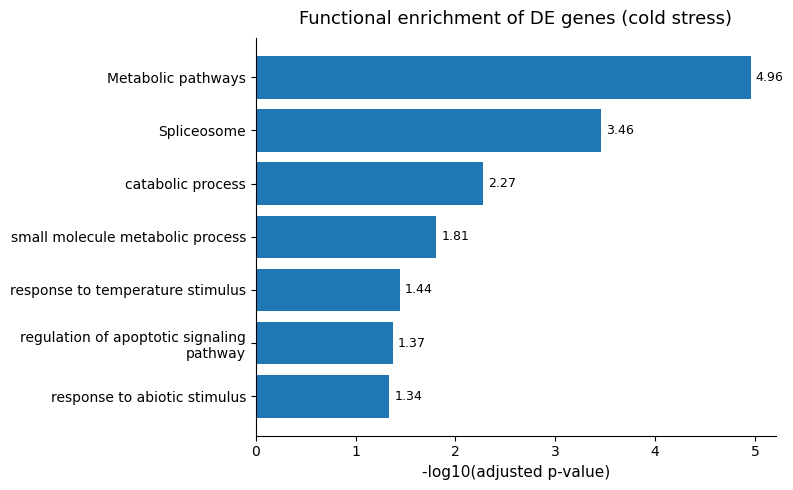

In [86]:
# top 10 enriched terms
top_terms = (
    res_plot
    .sort_values("p_value")
    .head(10)
    .copy()
)

top_terms["name_wrapped"] = top_terms["name"].apply(
    lambda x: "\n".join(textwrap.wrap(x, 35))
)

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.barh(
    top_terms["name_wrapped"],
    top_terms["minus_log10_p"]
)


ax.invert_yaxis()


ax.set_xlabel("-log10(adjusted p-value)", fontsize=11)
ax.set_title(
    "Functional enrichment of DE genes (cold stress)",
    fontsize=13,
    pad=10
)


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()
